In [8]:
from copy import deepcopy

from tqdm import tqdm
import numpy as np
from scipy.special import softmax
import gym
from gym.envs.toy_text import BlackjackEnv
import matplotlib.pyplot as plt

from double_blackjack import DoubleBJ
from count_double_blackjack import CountDBJ

In [2]:
np.random.seed(0)

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [3]:
# Простая функция реализующая стратегию выше
def simple_run(num_episodes):
    env = gym.make('Blackjack-v1')
    rewards = []
    for i_episode in range(num_episodes):
        observation = env.reset()
        for t in range(100):
            obs = observation[0]
            action = 1 if 18 > obs and obs < 22 else 0
            observation, reward, done, info = env.step(action)
            if done:
                rewards.append(reward)
                break
    env.close()
    return np.mean(rewards)

###### Сыграем 100 000 эпизодов по этой стратегии и посчитаем средний выигрыш:

In [4]:
f"Средний выигрыш (проигрыш) по наивной стратегии: {simple_run(10 ** 5)}"

'Средний выигрыш (проигрыш) по наивной стратегии: -0.11115'

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [5]:
# загрузим классы для обучения, у меня они получились объемные, поэтому реализовал в отдельном файле

from q_learn import Q_learn
from monte_carlo_control import MC_learn

In [6]:
def iterate(model, num_iter=100, n_iter=10**5):
    mean_rewards = []
    mean_val_rewards = []
    for _ in tqdm(range(num_iter)):
        train_r = model.train(n_iter)
        eval_r = model.eval(n_iter)
        mean_rewards.append(train_r)
        mean_val_rewards.append(eval_r)
    return mean_rewards, mean_val_rewards

In [7]:
# Обучим методом Q-learning
alpha = 0.01
gamma = 0.1
eps = 0.01
num_iter = 50
model = Q_learn(BlackjackEnv, alpha, gamma, eps)

mean_rewards1, mean_val_rewards1 = iterate(model, num_iter=num_iter)

100%|██████████| 50/50 [15:46<00:00, 18.94s/it]


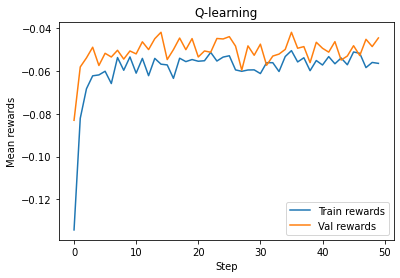

In [18]:
plt.plot(list(range(num_iter)), mean_rewards1, label="Train rewards")
plt.plot(list(range(num_iter)), mean_val_rewards1, label="Val rewards")
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("Q-learning")
plt.legend()

In [16]:
f"Максимальный средний выигрыш при обучении методом Q-learning: {np.max(mean_val_rewards1)}"

'Максимальный средний выигрыш при обучении методом Q-learning: -0.04198'

In [13]:
# Обучим методом off-policy Monte Carlo control

gamma = 1.0
eps = 0.01
off_policy = True
model = MC_learn(BlackjackEnv, gamma, eps, off_policy)
mean_rewards2, mean_val_rewards2 = iterate(model, num_iter=50)

100%|██████████| 50/50 [16:48<00:00, 20.18s/it]


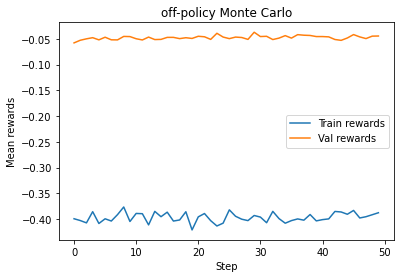

In [19]:
plt.plot(list(range(num_iter)), mean_rewards2, label="Train rewards")
plt.plot(list(range(num_iter)), mean_val_rewards2, label="Val rewards")
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("off-policy Monte Carlo")
plt.legend()

Так как behavior стратегия случайная, train rewards низкие.
Нарисуем средние награды на валидации

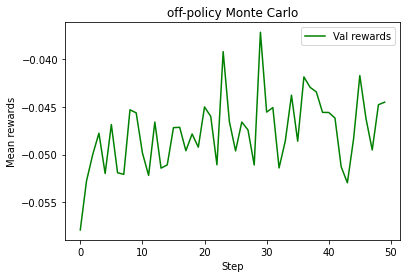

In [20]:
plt.plot(list(range(num_iter)), mean_val_rewards2, label="Val rewards", color='g')
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("off-policy Monte Carlo")
plt.legend()

In [21]:
f"Максимальный средний выигрыш при обучении методом off-policy Monte Carlo: {np.max(mean_val_rewards2)}"

'Максимальный средний выигрыш при обучении методом off-policy Monte Carlo: -0.03721'

In [22]:
# Теперь обучим методом on-policy Monte Carlo control

gamma = 1.0
eps = 0.01
off_policy = False
model = MC_learn(BlackjackEnv, gamma, eps, off_policy)
mean_rewards3, mean_val_rewards3 = iterate(model, num_iter=50)

100%|██████████| 50/50 [17:25<00:00, 20.92s/it]


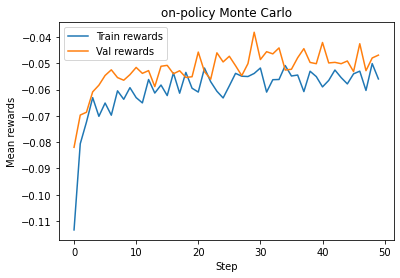

In [23]:
plt.plot(list(range(num_iter)), mean_rewards3, label="Train rewards")
plt.plot(list(range(num_iter)), mean_val_rewards3, label="Val rewards")
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("on-policy Monte Carlo")
plt.legend()

In [24]:
f"Максимальный средний выигрыш при обучении методом on-policy Monte Carlo: {np.max(mean_val_rewards3)}"

'Максимальный средний выигрыш при обучении методом on-policy Monte Carlo: -0.03817'

Дальше буду обучать только по off-policy Monte Carlo, так как результаты, полученные этим алгоритмом получились чуть лучше других

#### Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

Реализация в файле double_blackjack.py, class DoubleBJ

#### Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [ ]:
gamma = 1.0
eps = 0.01
off_policy = True
model = MC_learn(DoubleBJ, gamma, eps, off_policy)
mean_rewards3, mean_val_rewards3 = iterate(model, num_iter=50)

 54%|█████▍    | 27/50 [08:24<07:28, 19.51s/it]

#### Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

Реализация в файле count_double_blackjack, class CountDBJ

#### Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [ ]:
gamma = 1.0
eps = 0.01
model3 = MC_learn(CountDBJ, gamma, eps, False)
mean_rewards3, mean_val_rewards3, model3 = iterate(model3,
                                                   num_iter=100,
                                                   n_iter=10 ** 5)

Max reward on val: -0.15238, current train reward: -0.21431, validation reward: -0.15238
Max reward on val: -0.14231, current train reward: -0.15066, validation reward: -0.14231
Max reward on val: -0.13333, current train reward: -0.13898, validation reward: -0.13333
Max reward on val: -0.12496, current train reward: -0.13667, validation reward: -0.12496
Max reward on val: -0.12024, current train reward: -0.13341, validation reward: -0.12024
Max reward on val: -0.11691, current train reward: -0.11892, validation reward: -0.11691
Max reward on val: -0.11691, current train reward: -0.11504, validation reward: -0.11793
Max reward on val: -0.1064, current train reward: -0.12173, validation reward: -0.1064
Max reward on val: -0.1064, current train reward: -0.11498, validation reward: -0.10841
Max reward on val: -0.1064, current train reward: -0.11629, validation reward: -0.11061
Max reward on val: -0.1064, current train reward: -0.11244, validation reward: -0.10669
Max reward on val: -0.1020

In [ ]:
model3.eval(10 ** 7)

In [ ]:
mean_rewards3, mean_val_rewards3, model3 = iterate(model3,
                                                   num_iter=100,
                                                   n_iter=10 ** 5)

In [ ]:
# model3.eval(10 ** 6)